In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
from util.angle import *
from util.depth import *
from util.path import *
from util.visualizer import *
from util.object_dection import *
from util.selly_vision_api import *

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

#tensorrt model
loaded = tf.saved_model.load("./trt_fp16")
model = loaded.signatures["serving_default"]


ANGLE_CLASS = 18
ANGLE = angle_dict(ANGLE_CLASS)
ANGLE_IMG=angle_img(ANGLE, ANGLE_CLASS)

data = np.load("video_data.npz")
data = data["arr_0"]

img = data[:,0,:,:,:]
point_cloud = data[:,1,:,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


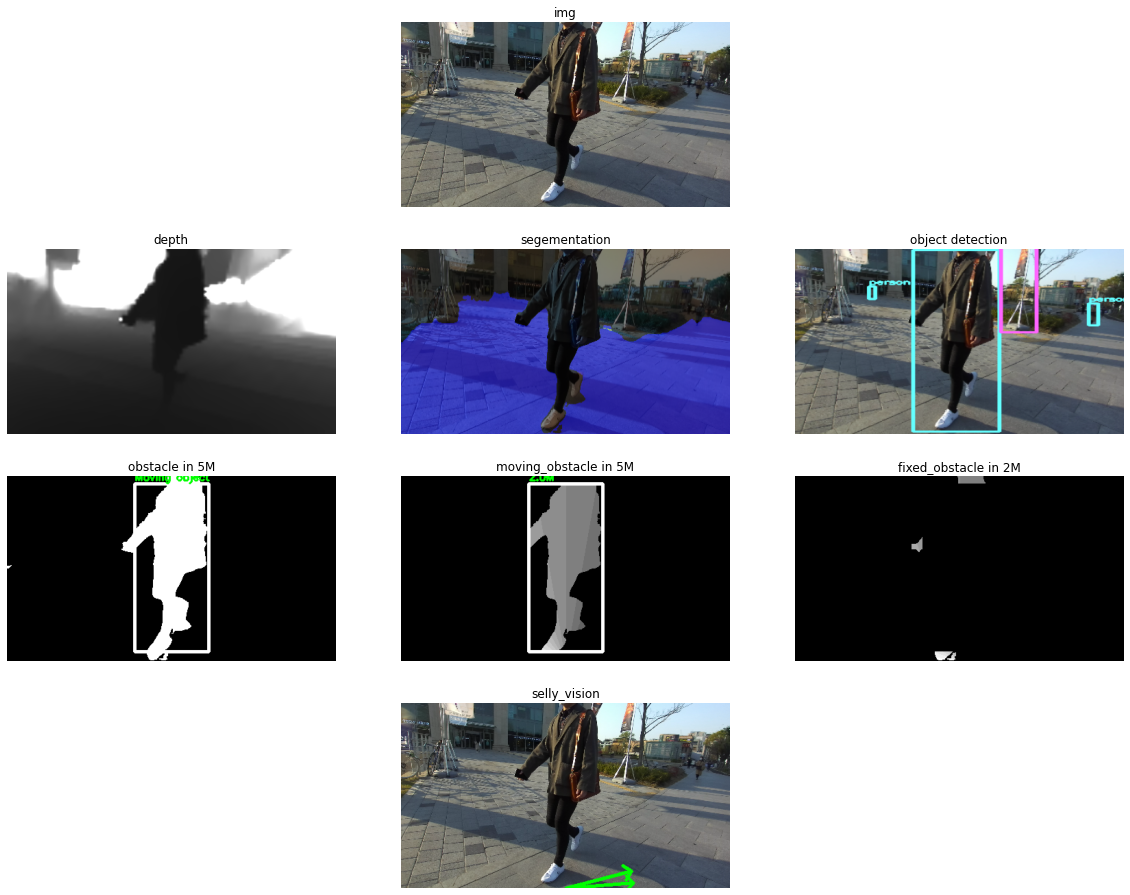

In [2]:
i = 1077
#plt.imshow(selly_vision_redis(img[i], point_cloud[i])[0]/255)
visualize(model, img[i], point_cloud[i], 5, 2, ANGLE, ANGLE_CLASS, ANGLE_IMG)

In [6]:
i =141 

im = img[i].copy()
pt = point_cloud[i].copy()

st = time.time()
for i in range(100):
    selly_vision_redis(im, pt)
print((time.time() - st)/100)

0.05790684461593628


In [89]:
i =1077


im = img[i].copy()
pt = point_cloud[i].copy()


st = time.time()

only_sidewalk = seg_predict(im,model)

depth = point2dist(pt,  1/4)

only_sidewalk_limited_dist = only_sidewalk.copy()
only_sidewalk_limited_dist[(depth>5)] = 0

obstacle = im.copy()
obstacle_depth = im.copy()
obstacle_depth[(depth>5)] = 0


obj_frame, moving_object, fixed_object  = YOLO(obstacle_depth)
moving_object = object_dist(moving_object, depth, 5)
fixed_object = object_dist(fixed_object, depth, 5)

obstacle[~((only_sidewalk ==0) & (obstacle_depth!=0))] = 0
redundant_obstacle = obstacle.copy()

for i in moving_object:
    redundant_obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 0
        
fixed_object_limit = fixed_object.copy()

for i in fixed_object:
    redundant_obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 0
    if fix_dist<i[2]:
        fixed_object_limit.remove(i)
        

redundant_obstacle[depth>2.5]=0

redundant_obstacle_angle = ANGLE_IMG.copy()
redundant_obstacle_angle[redundant_obstacle==0] = 0

selly_vision, angle = selly_vision_path(im.copy(), redundant_obstacle_angle.copy(), fixed_object_limit, moving_object, ANGLE_CLASS, ANGLE)

print(time.time() - st)

[0.98 0.97 0.95 0.94 0.91 0.71]
0.8522622585296631


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 479.5, 269.5, -0.5)

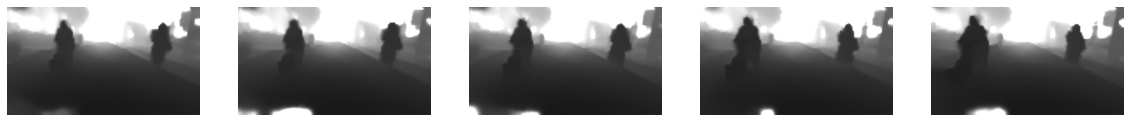

In [10]:
plt.figure(figsize = (20,10))
plt.subplot(1,5,1)
plt.imshow(dep[0]/20)
plt.axis("off")
plt.subplot(1,5,2)
plt.imshow(dep[1]/20)
plt.axis("off")

plt.subplot(1,5,3)
plt.imshow(dep[2]/20)
plt.axis("off")

plt.subplot(1,5,4)
plt.imshow(dep[3]/20)
plt.axis("off")

plt.subplot(1,5,5)
plt.imshow(dep[4]/20)
plt.axis("off")



(-0.5, 479.5, 269.5, -0.5)

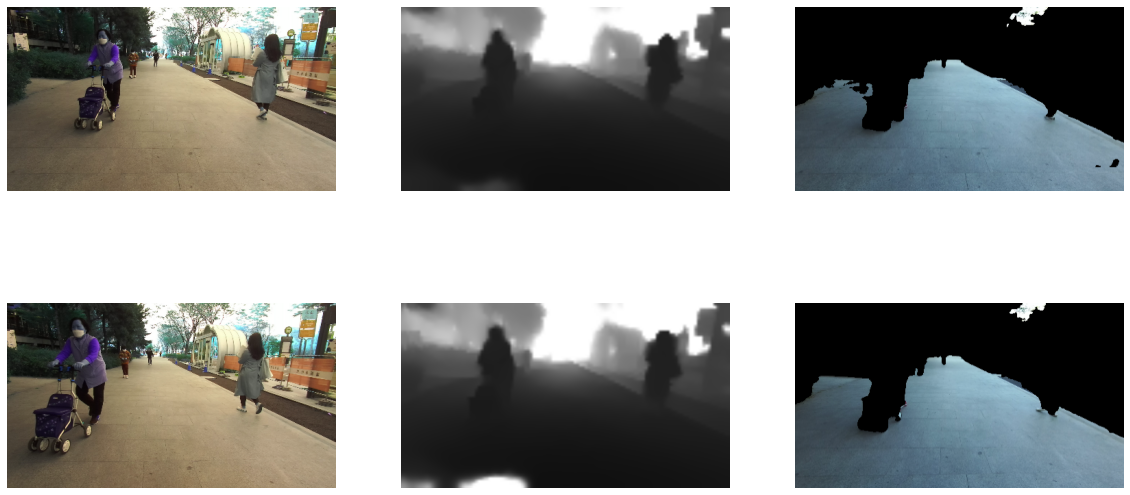

In [57]:
plt.figure(figsize = (20,10))



plt.subplot(2,3,1)
plt.imshow(img[140].copy()/255)
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(dep[0]/30)
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(seg[0]) 
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(im/255)
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(dep[1]/30)
plt.axis("off")

plt.subplot(2,3,6)
plt.imshow(seg[1]) 
plt.axis("off")



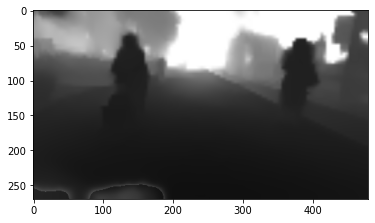

In [60]:
diff = dep[1]-dep[0]
diff[seg[0]==0]=0
diff[diff<5]=0
dep[1][diff!=0] = dep[0][diff!=0] 
plt.imshow(dep[1]/30)

(-0.5, 479.5, 269.5, -0.5)

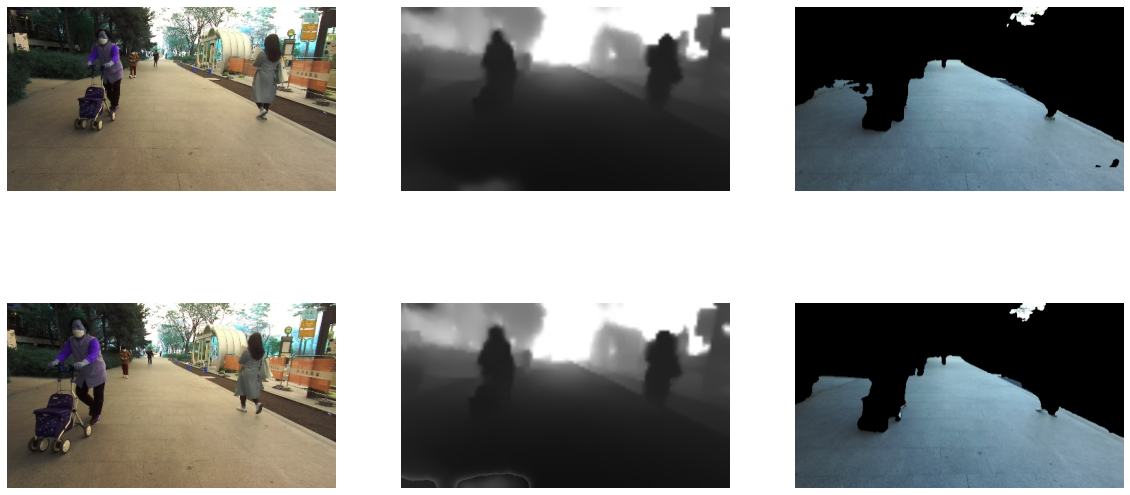

In [61]:
plt.figure(figsize = (20,10))



plt.subplot(2,3,1)
plt.imshow(img[140].copy()/255)
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(dep[0]/30)
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(seg[0]) 
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(im/255)
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(dep[1]/30)
plt.axis("off")

plt.subplot(2,3,6)
plt.imshow(seg[1]) 
plt.axis("off")



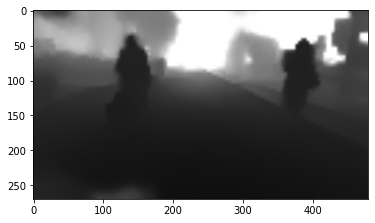

In [50]:
plt.imshow(dep[0].copy()/30)

In [ ]:
i=0
while True:
    st = time.time()
    cv2.imshow("",    selly_vision_redis(img[i], point_cloud[i])[0]/255)
    cv2.waitKey(1)
    print(time.time() - st)
    i+=1

In [78]:
flag=False

for i in range(0,1101):
        
    im = img[i].copy()
    pt = point_cloud[i].copy()

    only_sidewalk = seg_predict(im,model)
    depth = point2dist(pt,  1/4)
    
    if flag == False :
        dep_pre= depth.copy()
        flag = True
    else:
        depth_corr = depth.copy()
        diff = depth_corr - dep_pre
        diff[only_sidewalk==0]=0
        diff[diff<3]=0
        depth_corr[diff!=0] = dep_pre[diff!=0] 
        dep_pre= depth.copy()
        cv2.imshow("1",   depth/20)
        cv2.imshow("2",   depth_corr/20)

        cv2.waitKey(33)

KeyboardInterrupt: 